# Packages and Dataset Imports

In [1]:
import pandas as pd
import numpy as np
import os
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
import random
from scipy.stats import randint
import xgboost as xgb
import seaborn as sns


from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, average_precision_score, roc_curve, roc_auc_score, plot_confusion_matrix
from sklearn import model_selection
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=15)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
#dir_path = "https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/"
#data_path = os.path.join(dir_path, "data")
#original_file_path = os.path.join(data_path, "hr_attrition.csv")
#df = pd.read_csv(original_file_path)

url = 'https://raw.githubusercontent.com/McGill-MMA-EnterpriseAnalytics/HR_Analytics/main/data/hr_attrition.csv'
df = pd.read_csv(url)

In [3]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Custom Functions Summary
* From the data cleaning/transformation notebook

In [4]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### returns split data that has been standardized
def standardize(data):
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    df_num = [] # list of numerical variables
    cat_vars = ordinal_vars + ohe_vars + lab_vars
    cat_vars.append('Attrition') # target variable
    for i in list(data.columns):
        if i not in cat_vars:
            df_num.append(i)
    
    # standardizing numerical variables
    sc = StandardScaler()
    X = data[df_num]
    y = data['Attrition']
    X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
    X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 6)
    X_train_std = sc.fit_transform(X_train)
    X_test_std = sc.fit(X_test)
    X_val_std = sc.fit(X_val)
    
    
    return X_train_std, X_test_std, X_val_std, y_train, y_test, y_val


### returns DataFrame with non-standardized numerical variables and encoded categorical variables
def transform_encoding(data):
    # first dropping the unnecessary columns
    if 'EmployeeCount' in list(data.columns):
        data = data.drop(['EmployeeCount', 'EmployeeNumber', 'StandardHours', 'Over18'], axis = 'columns')
    
    # categorizing features
    ohe_vars = ['Department', 'Gender', 'MaritalStatus', 'OverTime']
    ordinal_vars = ['BusinessTravel', 'Education', 'EnvironmentSatisfaction', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'WorkLifeBalance']
    lab_vars = ['EducationField', 'JobRole']
    
    # filtering the data to exclude outliers in the YearsAtCompany and TotalWorkingYears variables
    data = data[data['YearsAtCompany'] < 30]
    data = data[data['TotalWorkingYears'] < 30]
    
    # ordinal encoding of the ordinal variables
    if type(data['BusinessTravel'][0]) == str:
        data['BusinessTravel'] = data['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    ord_pipeline = Pipeline([('ord_enc', OrdinalEncoder())])
    data[ordinal_vars] = ord_pipeline.fit_transform(data[ordinal_vars])

    # label encoding the education field and job role
    lbl_edu = LabelEncoder()
    edu_encoded = lbl_edu.fit_transform(data[['EducationField']])
    lbl_job = LabelEncoder()
    job_encoded = lbl_job.fit_transform(data[['JobRole']])
    data['EducationField'] = edu_encoded
    data['JobRole'] = job_encoded
    
    # using pd.get_dummies in lieu of OneHotEncoder
    data = pd.concat([data, pd.get_dummies(data[ohe_vars], drop_first = True)], axis = 'columns')
    data = data.drop(ohe_vars, axis = 1)
    
    if type(data['Attrition'][0]) == str:
        data['Attrition'] = data['Attrition'].replace({'Yes': 1, 'No': 0})
    
    return data

In [5]:
df_enc = transform_encoding(df)
X_train_std, X_test_std, X_val_std, y_train, y_test, y_val = standardize(df_enc)
X_train_std

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


array([[ 0.62766673, -0.85938873,  2.10792391, ...,  1.08978804,
        -0.68739446,  1.64248628],
       [-0.74924025,  0.35071447, -0.005394  , ..., -0.91760963,
         1.45476878, -0.60883309],
       [ 0.74240897, -1.01841667,  2.10792391, ...,  1.08978804,
        -0.68739446,  1.64248628],
       ...,
       [ 0.74240897,  0.57186269,  0.86479573, ...,  1.08978804,
        -0.68739446,  1.64248628],
       [ 0.62766673, -1.33895735, -0.50264527, ...,  1.08978804,
        -0.68739446, -0.60883309],
       [ 1.08663572,  0.4650158 , -0.99989654, ..., -0.91760963,
         1.45476878, -0.60883309]])

In [6]:
#ROC Plot
def plot_roc_curve(fpr, tpr, roc_auc):
#    plt.style.use('classic')
    sns.set_style("darkgrid")
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b+', label = 'AUC = %0.2f' % roc_auc, linestyle = '-')
    plt.fill_between(fpr, tpr, alpha = 0.5, color='gold')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [7]:
#Precision / Recall Plot
def plot_pr_curve(precision, recall, average_precision):
#    plt.style.use('classic')
    sns.set_style("darkgrid")
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2, color='red')   
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    plt.show()

In [8]:
#Learning curve
def plot_learning_curves(X_train, y_train,
                         X_test, y_test,
                         clf,
                         train_marker='o',
                         test_marker='^',
                         scoring='misclassification error',
                         suppress_plot=False, print_model=True,
                         style='fivethirtyeight',
                         legend_loc='best'):
   
    if scoring != 'misclassification error':
        from sklearn import metrics

        scoring_func = {
            'accuracy': metrics.accuracy_score,
            'average_precision': metrics.average_precision_score,
            'f1': metrics.f1_score,
            'f1_micro': metrics.f1_score,
            'f1_macro': metrics.f1_score,
            'f1_weighted': metrics.f1_score,
            'f1_samples': metrics.f1_score,
            'log_loss': metrics.log_loss,
            'precision': metrics.precision_score,
            'recall': metrics.recall_score,
            'roc_auc': metrics.roc_auc_score,
            'adjusted_rand_score': metrics.adjusted_rand_score,
            'mean_absolute_error': metrics.mean_absolute_error,
            'mean_squared_error': metrics.mean_squared_error,
            'median_absolute_error': metrics.median_absolute_error,
            'r2': metrics.r2_score}

        if scoring not in scoring_func.keys():
            raise AttributeError('scoring must be in', scoring_func.keys())

    else:
        def misclf_err(y_predict, y):
            return (y_predict != y).sum() / float(len(y))

        scoring_func = {
            'misclassification error': misclf_err}

    training_errors = []
    test_errors = []

    rng = [int(i) for i in np.linspace(0, X_train.shape[0], 11)][1:]
    for r in rng:
        model = clf.fit(X_train[:r], y_train[:r])

        y_train_predict = clf.predict(X_train[:r])
        y_test_predict = clf.predict(X_test)

        train_misclf = scoring_func[scoring](y_train[:r], y_train_predict)
        training_errors.append(train_misclf)

        test_misclf = scoring_func[scoring](y_test, y_test_predict)
        test_errors.append(test_misclf)

    if not suppress_plot:
        with plt.style.context(style):
            plt.plot(np.arange(10, 101, 10), training_errors,
                     label='training set', marker=train_marker)
            plt.plot(np.arange(10, 101, 10), test_errors,
                     label='test set', marker=test_marker)
            plt.xlabel('Training set size in percent')

    if not suppress_plot:
        with plt.style.context(style):
            plt.ylabel('Performance')
            if print_model:
                plt.title('Learning Curves\n\n{}\n'.format(model))
            plt.legend(loc=legend_loc, numpoints=1)
            plt.xlim([0, 110])
            max_y = max(max(test_errors), max(training_errors))
            min_y = min(min(test_errors), min(training_errors))
            plt.ylim([min_y - min_y * 0.15, max_y + max_y * 0.15])
    errors = (training_errors, test_errors)
    return errors

In [9]:
#Validation curve
from yellowbrick.model_selection import (
ValidationCurve,
)

def plot_val_curve(X,y, clf):
    fig, ax = plt.subplots(figsize=(6, 4))
    vc_viz = ValidationCurve(clf, param_name="max_depth", param_range=np.arange(1, 11), cv=10, n_jobs=-1, )
    vc_viz.fit(X, y)
    vc_viz.poof()

In [10]:
def clf_score(clf, X_train, y_train, X_val, y_val, train=True):
    if train:
        print("Train Result:\n")
        print("Accuracy: {0:.4f}\n".format(accuracy_score(y_train, clf.predict(X_train))))
        print("F1 score: {0:.4f}\n".format(f1_score(y_train, clf.predict(X_train), average='weighted')))
        print("Classification Report: \n {}\n".format(classification_report(y_train, clf.predict(X_train))))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, clf.predict(X_train))))

        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
        
        plot_learning_curves(X_train, y_train, X_val, y_val, clf)
        plt.show()

    elif train == False:
        print("Validation Result:\n")
        print("Accuracy: {0:.4f}\n".format(accuracy_score(y_val, clf.predict(X_val))))
        print("F1 score: {0:.4f}\n".format(f1_score(y_val, clf.predict(X_val), average='weighted')))
        
        precision, recall, _ = precision_recall_curve(y_val, clf.predict(X_val))
        average_precision = average_precision_score(y_val, clf.predict(X_val))
        plot_pr_curve(precision, recall, average_precision)
        
        fpr, tpr, _ = roc_curve(y_val, clf.predict(X_val))
        roc_auc = roc_auc_score(y_val, clf.predict(X_val))
        print("AUC-ROC: {0:.3f}\n".format(roc_auc))
        plot_roc_curve(fpr, tpr, roc_auc)
        
        print("Classification Report: \n {}\n".format(classification_report(y_val, clf.predict(X_val))))
        print("Confusion Matrix: \n {}\n".format(pd.DataFrame(metrics.confusion_matrix(y_val, clf.predict(X_val),
                                                                  labels=[0,1]),index=['true:0','true:1'], columns=['pred:0','pred:1'])))

        
        plot_learning_curves(X_train, y_train, X_val, y_val, clf)
        plt.show()
        
        print("End of validation Result\n")

In [11]:
def clf_evals(clf, X_train, y_train, X_val, y_val, X_test, y_test):
    acc_score_val = accuracy_score(y_val, clf.predict(X_val))
    avg_precision_val = average_precision_score(y_val, clf.predict(X_val))
    roc_auc_val = roc_auc_score(y_val, clf.predict(X_val))
    
    acc_score_test = accuracy_score(y_test, clf.predict(X_test))
    avg_precision_test = average_precision_score(y_test, clf.predict(X_test))
    roc_auc_test = roc_auc_score(y_test, clf.predict(X_test))
    
    # function to return metrics of a classifier as a dictionary
    
    return {'Accuracy Validation': acc_score_val, 'Accuracy Test': acc_score_test, 'Precision Validation': avg_precision_val, 'Precision Test': avg_precision_test, 'AUC-ROC Validation': roc_auc_val, 'AUC-ROC Test': roc_auc_test}

In [12]:
# function which returns the most important features using RFE with a desired number of features and desired estimator
def important_features(estim, num):
    X_enc = df_enc.drop('Attrition', axis = 'columns')
    y_enc = df_enc['Attrition']

    rfe = RFE(estimator = estim, step = 1, n_features_to_select = num)
    rfe.fit(X_enc, y_enc)

    feats = pd.DataFrame(rfe.ranking_)
    feats['Feature'] = X_enc.columns

    feats_to_use = list(feats[feats[0] < 2]['Feature'])
    
    return feats_to_use

In [13]:
# takes in list of important features, applies train_test_split and SMOTE on the dataset using those features
def split_and_smote(feats_to_use):
    X_enc = df_enc[feats_to_use]
    y_enc = df_enc['Attrition']

    X_enc_train, X_enc_val_test, y_enc_train, y_enc_val_test = train_test_split(X_enc, y_enc, test_size = 0.3, random_state = 6)

    X_enc_val, X_enc_test, y_enc_val, y_enc_test = train_test_split(X_enc_val_test, y_enc_val_test, test_size = 0.5, random_state = 6)

    sm = SMOTE(random_state=42)
    X_enc_train_sm, y_enc_train_sm = sm.fit_sample(X_enc_train, y_enc_train)
    
    return X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, X_enc_test, y_enc_test

# Final Model - Convenient Summary

Below is the final model, methods of finding this model are described below. This chunk is to conveniently place the model from the time of writing in the notebook.

In [14]:
final_parameters = {'n_estimators': 188, 'learning_rate': 0.9834785001549696}

final_parameters_metrics = {
     'Accuracy Validation': 0.8403755868544601,
     'Accuracy Test': 0.8497652582159625,
     'Precision Validation': 0.43681819916790715,
     'Precision Test': 0.34697769953051644,
     'AUC-ROC Validation': 0.7618406125921726,
     'AUC-ROC Test': 0.7315262430939227,
     'Accuracy Score': 0.8678371142226563
}

In [15]:
feats_to_use = important_features(AdaBoostClassifier(n_estimators = 40, random_state = 6), 29)

X = df_enc[feats_to_use]
y = df_enc['Attrition']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 6)

sm = SMOTE(random_state = 6)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

In [16]:
ada = AdaBoostClassifier(**final_parameters, random_state = 6)
ada.fit(X_train_sm, y_train_sm)

AdaBoostClassifier(learning_rate=0.9834785001549696, n_estimators=188,
                   random_state=6)

### Validation Set Metrics

Validation Result:

Accuracy: 0.8404

F1 score: 0.8431



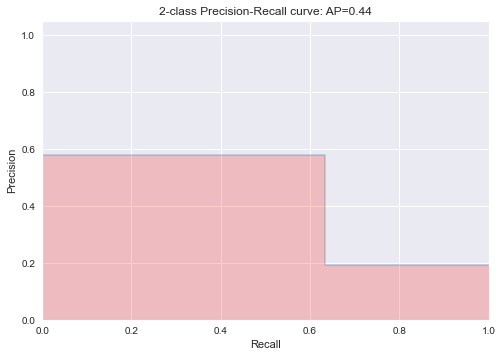

AUC-ROC: 0.762



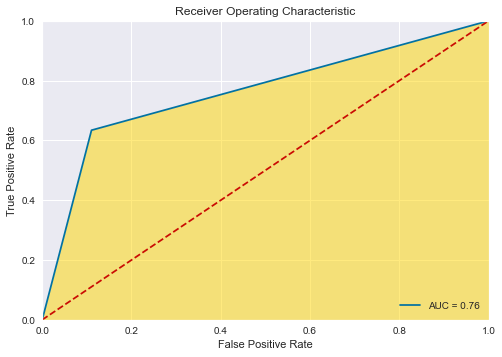

Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.89      0.90       172
           1       0.58      0.63      0.60        41

    accuracy                           0.84       213
   macro avg       0.74      0.76      0.75       213
weighted avg       0.85      0.84      0.84       213


Confusion Matrix: 
         pred:0  pred:1
true:0     153      19
true:1      15      26



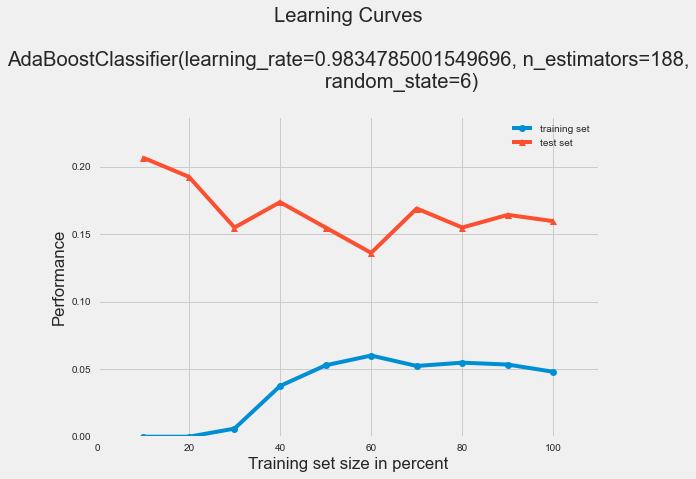

End of validation Result



In [17]:
clf_score(ada, X_train_sm, y_train_sm, X_val, y_val, train = False)

### Test Set Metrics

Validation Result:

Accuracy: 0.8498

F1 score: 0.8533



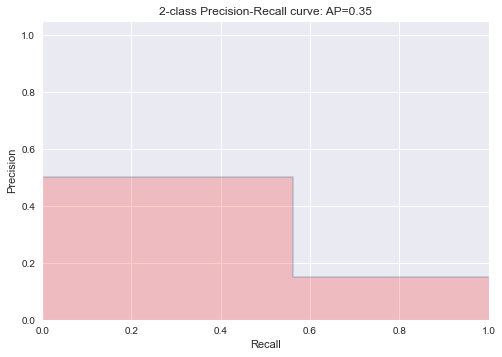

AUC-ROC: 0.732



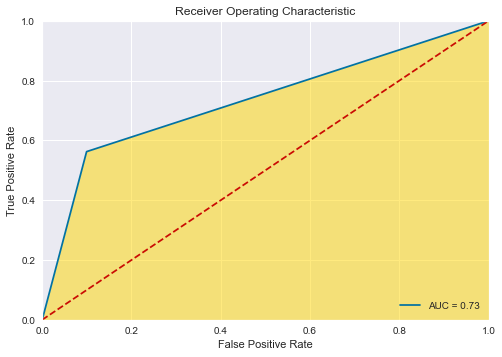

Classification Report: 
               precision    recall  f1-score   support

           0       0.92      0.90      0.91       181
           1       0.50      0.56      0.53        32

    accuracy                           0.85       213
   macro avg       0.71      0.73      0.72       213
weighted avg       0.86      0.85      0.85       213


Confusion Matrix: 
         pred:0  pred:1
true:0     163      18
true:1      14      18



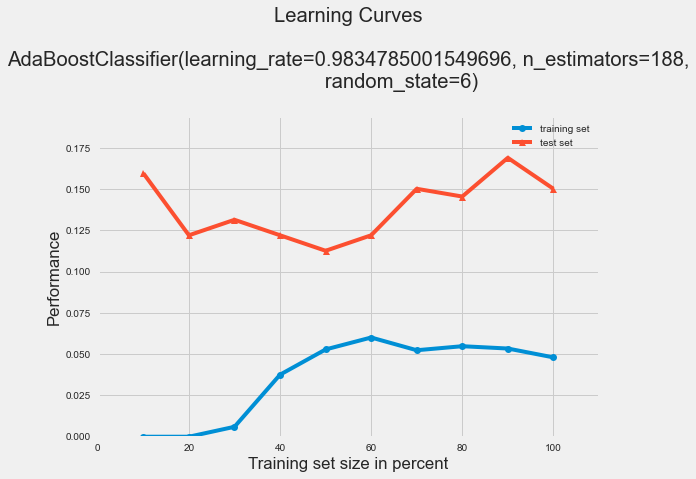

End of validation Result



In [18]:
clf_score(ada, X_train_sm, y_train_sm, X_test, y_test, train = False)

### Other Metrics

In [19]:
pd.DataFrame({'Score': clf_evals(ada, X_train_sm, y_train_sm, X_val, y_val, X_test, y_test)})

,Score
AUC-ROC Test,0.731526
AUC-ROC Validation,0.761841
Accuracy Test,0.849765
Accuracy Validation,0.840376
Precision Test,0.346978
Precision Validation,0.436818


# From Model Selection

The best performing model in the selection process was `LGBMClassifier`. We begin by tuning hyperparameters for an `LGBMClassifier` model in an attempt to have an optimally performing model.<br>
First, we use RFE to select the most important features, one at a time, and test model performance as we recursively add features to the model. By doing this, we see the optimal number of features, and ensure that these features are the most important ones according to the `LGBMClassifier` feature importances.

## Refining Features for LGBMClassifier

In [20]:
mets = dict()

for i in range(1, 33):
    
    feats_to_use = important_features(AdaBoostClassifier(n_estimators = 40, random_state = 6), i)
    X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, X_enc_test, y_enc_test = split_and_smote(feats_to_use)

    clf = AdaBoostClassifier(n_estimators = 40, random_state = 6)
    clf.fit(X_enc_train_sm, y_enc_train_sm)
    
    mets[i] = clf_evals(clf, X_enc_train_sm, y_enc_train_sm, X_enc_val, y_enc_val, X_enc_test, y_enc_test)
    
feature_metrics = pd.DataFrame.from_dict(mets).T

In [14]:
feature_metrics

,Accuracy Validation,Accuracy Test,Precision Validation,Precision Test,AUC-ROC Validation,AUC-ROC Test
1,0.591549,0.591549,0.208106,0.162533,0.542754,0.541005
2,0.690141,0.647887,0.237529,0.176131,0.594512,0.574154
3,0.633803,0.577465,0.220685,0.159713,0.568917,0.532718
4,0.615023,0.624413,0.223488,0.160570,0.575865,0.534617
5,0.615023,0.619718,0.228083,0.155541,0.585153,0.518992
6,0.713615,0.732394,0.231822,0.172731,0.581183,0.559565
7,0.708920,0.723005,0.229670,0.150912,0.578276,0.502590
8,0.737089,0.755869,0.269416,0.237668,0.632870,0.663415
9,0.732394,0.760563,0.272808,0.223307,0.639251,0.640452
10,0.751174,0.760563,0.279384,0.214826,0.641591,0.627590


It looks like 29 features using RFE is about optimal for LGBMClassifier.

**Note:** Since the compute time is not an issue here, we opt to use all 22 features instead of using dimensionality reduction techniques so as to preserve all variance in the data.

In [16]:
feats_to_use = important_features(LGBMClassifier(n_estimators = 40, random_state = 6), 29)
feats_to_use

['Age',
 'BusinessTravel',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EducationField',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobRole',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager',
 'Department_Research & Development',
 'Gender_Male',
 'MaritalStatus_Single',
 'OverTime_Yes']

There is actually not a linear relationship between variables like `DailyRate`, `HourlyRate`, etc. which we can detect, so we kept the variables selected in the analysis.

In [19]:
X = df_enc[feats_to_use]
y = df_enc['Attrition']

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size = 0.3, random_state = 6)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size = 0.5, random_state = 6)

sm = SMOTE(random_state = 6)
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

## Randomized Search CV

#### Using ROC-AUC Score

In [22]:
params = {
    'n_estimators': [x for x in range(10, 500)],
    'learning_rate': [random.uniform(0, 1.5) for x in range(100)]
}

ada = AdaBoostClassifier(random_state = 6)
rnd = RandomizedSearchCV(ada, param_distributions = params, n_iter = 30, scoring = 'roc_auc', random_state = 6)
rnd.fit(X_train_sm, y_train_sm)

RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=6), n_iter=30,
                   param_distributions={'learning_rate': [0.7333312835520109,
                                                          1.0231467715394635,
                                                          0.32628040552665466,
                                                          1.1410137991036973,
                                                          1.2248948808193747,
                                                          1.0469482211492505,
                                                          0.9748325613425195,
                                                          0.25041969110727896,
                                                          0.9978920350100946,
                                                          0.6473747390503684,
                                                          0.8307569585967975,
                                                          0.5035

In [23]:
cvres = rnd.cv_results_
for score in cvres["mean_test_score"]:
    print(score)

0.9390200727880863
0.9192546392191666
0.9402393210385732
0.9389054667555585
0.9363328938001484
0.9404513661021692
0.9359454410963238
0.9331389188526706
0.9315139643778201
0.9327794548803394
0.929317457406279
0.933262173577073
0.9370328293912973
0.9350744004805023
0.9396622055641947
0.9400349250692983
0.9410973234254382
0.9402906481998986
0.8992363291996354
0.8334856488213875
0.9416447986593223
0.936384959794448
0.9367727167236147
0.9392439826400327
0.934471295469737
0.9372961146946924
0.942412228815703
0.9305099338266419
0.9363141187504509
0.9276424795929987


In [24]:
print(rnd.best_score_)
print(rnd.best_params_)

0.942412228815703
{'n_estimators': 145, 'learning_rate': 0.8307569585967975}


Storing the parameters and metrics in a dictionary

In [25]:
par = dict()
iteration_mets = dict()

In [26]:
ada = AdaBoostClassifier(**rnd.best_params_)
par['Iteration 1'] = rnd.best_params_
ada.fit(X_train_sm, y_train_sm)
iteration_mets['Iteration 1'] = clf_evals(ada, X_train_sm, y_train_sm, X_val, y_val, X_test, y_test)

#### Using Accuracy Score

In [27]:
params = {
    'n_estimators': [x for x in range(10, 500)],
    'learning_rate': [random.uniform(0, 1.5) for x in range(100)]
}

ada = AdaBoostClassifier(random_state = 6)
rnd = RandomizedSearchCV(ada, param_distributions = params, n_iter = 30, scoring = 'accuracy', random_state = 6)
rnd.fit(X_train_sm, y_train_sm)

RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=6), n_iter=30,
                   param_distributions={'learning_rate': [0.48312817963625504,
                                                          0.7103646431254176,
                                                          1.2542691940097248,
                                                          1.3028377160812514,
                                                          0.29879057094347966,
                                                          0.3664549196947722,
                                                          1.2803445627436705,
                                                          0.8703616892597039,
                                                          0.32317410780818895,
                                                          0.9193098895150409,
                                                          1.0336307212004825,
                                                          1.233

In [28]:
cvres = rnd.cv_results_
for score in cvres["mean_test_score"]:
    print(score)

0.8564058033937553
0.8341672998299504
0.8636311009804987
0.8582184594232787
0.8654292847063931
0.8654329027823003
0.8600220702630341
0.857015449184124
0.8582184594232787
0.8558070118311083
0.8582148413473714
0.8588226780997866
0.8642244654292845
0.8540106371431673
0.8546003835160463
0.8594160425485725
0.8515829082094143
0.8666359130214552
0.8636292919425449
0.8540052100293064
0.8534082275046131
0.8612305076160498
0.8594232787003871
0.8630286913419443
0.8582220774991859
0.8600256883389413
0.8624262817033902
0.8582202684612323
0.8534046094287058
0.8612196533883282


In [29]:
print(rnd.best_score_)
print(rnd.best_params_)

0.8666359130214552
{'n_estimators': 193, 'learning_rate': 1.0336307212004825}


In [30]:
ada = AdaBoostClassifier(**rnd.best_params_)
par['Iteration 2'] = rnd.best_params_
ada.fit(X_train_sm, y_train_sm)
iteration_mets['Iteration 2'] = clf_evals(ada, X_train_sm, y_train_sm, X_val, y_val, X_test, y_test)

## Refining the Randomized Search

In [31]:
params = {
    'n_estimators': [x for x in range(120, 225)],
    'learning_rate': [random.uniform(0.8, 1.1) for x in range(100)]
}

ada = AdaBoostClassifier(random_state = 6)
rnd = RandomizedSearchCV(ada, param_distributions = params, n_iter = 30, scoring = 'accuracy', random_state = 6)
rnd.fit(X_train_sm, y_train_sm)

RandomizedSearchCV(estimator=AdaBoostClassifier(random_state=6), n_iter=30,
                   param_distributions={'learning_rate': [0.8695821563021913,
                                                          1.0304278927873998,
                                                          0.9291197191390768,
                                                          0.9401265676691193,
                                                          0.8444923268661938,
                                                          0.935403446627063,
                                                          0.844381821270221,
                                                          0.8163926895515063,
                                                          0.9957101689664305,
                                                          1.0965246144831364,
                                                          0.982349068528175,
                                                          1.074868160

In [32]:
cvres = rnd.cv_results_
for score in cvres["mean_test_score"]:
    print(score)

0.863025073266037
0.8606244799015883
0.8588154419479721
0.8606335250913565
0.870243134700966
0.869036506385904
0.8624317088172511
0.8678316871087957
0.8606280979774954
0.8660298853069938
0.8684413328991643
0.8666341039835016
0.8624335178552046
0.8612305076160498
0.8672365136220558
0.86602807626904
0.8624298997792973
0.8648304931437462
0.8642317015810992
0.8612286985780961
0.8576232859365389
0.8600238793009878
0.8642262744672383
0.8618220630268822
0.8654310937443468
0.863030500379898
0.8630286913419443
0.8678298780708419
0.8660335033829011
0.8606244799015883


In [33]:
print(rnd.best_score_)
print(rnd.best_params_)

0.870243134700966
{'n_estimators': 142, 'learning_rate': 0.8726742828675592}


In [34]:
ada = AdaBoostClassifier(**rnd.best_params_)
par['Iteration 3'] = rnd.best_params_
ada.fit(X_train_sm, y_train_sm)
iteration_mets['Iteration 3'] = clf_evals(ada, X_train_sm, y_train_sm, X_val, y_val, X_test, y_test)

In [35]:
pd.DataFrame.from_dict(iteration_mets).T

,Accuracy Validation,Accuracy Test,Precision Validation,Precision Test,AUC-ROC Validation,AUC-ROC Test
Iteration 1,0.849765,0.835681,0.453860,0.282088,0.767655,0.671789
Iteration 2,0.835681,0.835681,0.428853,0.314510,0.758934,0.710376
Iteration 3,0.854460,0.854460,0.469830,0.344097,0.779850,0.721426


It seems like the refinements made in the third iteration are pretty effective.

In [38]:
params = {
    'n_estimators': [x for x in range(120, 225)],
    'learning_rate': [random.uniform(0.8, 1.1) for x in range(100)]
}

par = dict()
iteration_mets = dict()
for i in range(6):
    ada = AdaBoostClassifier(random_state = 6)
    rnd = RandomizedSearchCV(ada, param_distributions = params, n_iter = 30, scoring = 'accuracy')
    rnd.fit(X_train_sm, y_train_sm)
    # taking best parameters from above and storing them, then fitting a new classifier on them to evaluate
    ada = AdaBoostClassifier(**rnd.best_params_)
    par['Iteration '+str(i)] = rnd.best_params_
    ada.fit(X_train_sm, y_train_sm)
    
    mets = clf_evals(ada, X_train_sm, y_train_sm, X_val, y_val, X_test, y_test)
    mets['Accuracy Score'] = rnd.best_score_
    iteration_mets['Iteration '+str(i)] = mets

In [39]:
pd.DataFrame.from_dict(iteration_mets).T

,Accuracy Validation,Accuracy Test,Precision Validation,Precision Test,AUC-ROC Validation,AUC-ROC Test,Accuracy Score
Iteration 0,0.840376,0.826291,0.429627,0.280705,0.752552,0.679126,0.869646
Iteration 1,0.854460,0.830986,0.462989,0.297340,0.770562,0.694751,0.870240
Iteration 2,0.835681,0.854460,0.421570,0.333182,0.749645,0.708564,0.870840
Iteration 3,0.835681,0.849765,0.421570,0.336048,0.749645,0.718664,0.868440
Iteration 4,0.845070,0.840376,0.445145,0.310411,0.764748,0.700276,0.868447
Iteration 5,0.840376,0.849765,0.436818,0.346978,0.761841,0.731526,0.867837


The differences are pretty negligble - as parameters are changed some metrics improve slightly while others regress slightly. It seems that **iteration 5** performed best in this test, and so those parameters will be used in the final model (the determination of *best* output is somewhat subjective here).

# Final Model

#### Final model from time of writing is detailed beneath the custom function definition section above.